In [56]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def add_project_root(project_name: str = "extrema_lab"):
    cwd = os.getcwd()
    path_parts = cwd.split(os.sep)

    for i in range(len(path_parts), 0, -1):
        potential_root = os.sep.join(path_parts[:i])
        if os.path.basename(potential_root) == project_name:
            root = os.path.dirname(potential_root)
            if root not in sys.path:
                sys.path.append(root)
            print(f"added sys.path: {root}")
            return

    print(f"failed to fund {project_name}")


add_project_root("extrema_lab")
from extrema_lab.feature_eng.operator.utils_tools import *

added sys.path: C:\quant\work


In [257]:
symbol = "ETHUSDT"
threshold = 0.0067
feat_cal_window = 150
feat_norm_window = 150
feat_norm_rolling_mean_window = 150

origin_df = process_single_symbol(
    symbol,
    str(threshold),
    feat_cal_window,
    feat_norm_window,
    feat_norm_rolling_mean_window,
)


In [258]:
origin_df

timestamp,px,sum_buy_sz,sum_sell_sz,ts_duration,px_pct,bs_imbalance,oi_sum_open_interest,oi_sum_open_interest_value,funding_funding_interval_hours,funding_last_funding_rate,premium_open,adjusted_funding_rate,funding_oi,premium_oi,funding_premium,factor_triplet,premium_funding_spread,oi_sum_open_interest_value_roll_mean_ratio_12,oi_sum_open_interest_value_pct_change_sum_12,oi_sum_open_interest_value_roll_mean_ratio_72,oi_sum_open_interest_value_pct_change_sum_72,oi_sum_open_interest_value_roll_mean_ratio_144,oi_sum_open_interest_value_pct_change_sum_144,oi_sum_open_interest_value_roll_mean_ratio_288,oi_sum_open_interest_value_pct_change_sum_288,premium_funding_spread_sum_288,adjusted_funding_rate_sum_288,premium_open_sum_288,funding_oi_roll_mean_ratio_288,premium_oi_roll_mean_ratio_288,factor_triplet_roll_mean_ratio_288,premium_oi_dev_144,z_oi_sum_open_interest,z_oi_sum_open_interest_value,z_funding_oi,z_premium_oi,…,z_oi_dn_divergence_short_term_zscaled,z_sum_sz_px_pct_rol_sum_150_zscaled,z_px_velo_rol_mean_150_zscaled,z_oi_px_diff_150_zscaled,oi_di_zscaled,oi_di_long_term_zscaled,oi_di_short_term_zscaled,taker_px_pct_diff_zscaled,factor_impact_momentum_zscaled,factor_impact_sensitivity_zscaled,factor_orderflow_sz_momentum_zscaled,factor_orderflow_sz_sensitivity_zscaled,z_oi_di_zscaled,z_oi_di_long_term_zscaled,z_taker_px_pct_diff_zscaled,z_factor_impact_momentum_zscaled,z_factor_impact_sensitivity_zscaled,z_factor_orderflow_sz_momentum_zscaled,z_factor_orderflow_sz_sensitivity_zscaled,factor_order_momentum_divergence_zscaled,factor_order_sentiment_divergence_zscaled,corr_px_oi_sum_open_interest_value_150_zscaled,z_signal_px_oi_sum_open_interest_value_150_zscaled,z_factor_order_momentum_divergence_zscaled,z_factor_order_sentiment_divergence_zscaled,z_corr_px_oi_sum_open_interest_value_150_zscaled,z_px_oi_corr_activation_zscaled,px_risk_factor_zscaled,px_drawdown_zscaled,px_rebound_zscaled,z_px_risk_factor_zscaled,z_px_drawdown_zscaled,z_px_rebound_zscaled,px_dd_rb_zscaled,micro_trend_factor_150_zscaled,z_px_dd_rb_zscaled,z_micro_trend_factor_150_zscaled
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1719796327045000,3482.94,38834.506,25237.172,3.50461e8,0.006703,13597.334,1.17340256e8,341066.7279,8.0,-0.000012,-0.000641,-0.000001,-0.491989,-218.45665,9.2394e-10,0.000315,-0.000639,0.999391,-0.001693,0.994501,-0.013191,0.991087,-0.009141,0.993016,0.00037,-0.184051,-0.000415,-0.184467,0.993016,0.993016,0.993016,-0.008913,0.835388,-1.538328,1.538322,1.538328,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1719797606385000,3506.28,64704.413,59558.72,1.2793e9,0.006701,5145.693,1.17745727e8,337042.298554,8.0,-0.000012,-0.000641,-0.000001,-0.486184,-215.878963,9.2394e-10,0.000311,-0.000639,0.991268,-0.01232,0.98389,-0.022001,0.979878,-0.018751,0.981455,-0.014118,-0.184051,-0.000415,-0.184467,0.981455,0.981455,0.981455,-0.020122,1.232091,-3.0,3.0,3.0,…,0.0,0.30443,0.30443,-0.30443,0.30443,0.304419,0.304416,0.30443,0.30443,0.30443,0.30443,0.30443,0.30443,0.30443,0.30443,0.30443,0.30443,0.30443,0.30443,0.304424,-0.30443,0.30443,0.0,0.30443,-0.30443,0.30443,0.0,0.30443,0.0,0.30443,0.30443,0.0,0.30443,0.30443,0.0,0.30443,0.0
1719822615163000,3482.78,227139.059,233676.488,2.5009e10,-0.006702,-6537.429,1.19417686e8,342858.702268,8.0,-0.000012,-0.000641,-0.000001,-0.494574,-219.604427,9.2394e-10,0.000317,-0.000639,1.002624,0.00348,1.008153,0.012347,1.006324,-0.002904,1.000875,0.003453,-0.184051,-0.000415,-0.184467,1.000875,1.000875,1.000875,0.006324,2.182307,0.115515,-0.115515,-0.115515,…,0.0,-0.058264,-0.05561,0.069665,-0.067781,0.029375,0.01056,-0.012207,-0.062834,-0.066322,0.315389,0.418947,-0

In [259]:
prices_np = origin_df["px"].to_numpy()[:20000]
avg_steps_05pct = avg_steps_to_volatility(prices_np, 0.005)
avg_steps_1pct = avg_steps_to_volatility(prices_np, 0.01)
avg_steps_2pct = avg_steps_to_volatility(prices_np, 0.02) 
avg_steps_5pct = avg_steps_to_volatility(prices_np, 0.05) 
avg_steps_5pct = 75
print("波动 ±0.5% 的均值步数:", avg_steps_05pct)
print("波动 ±1% 的均值步数:", avg_steps_1pct)
print("波动 ±2% 的均值步数:", avg_steps_2pct)
print("波动 ±5% 的均值步数:", avg_steps_5pct)

origin_df = origin_df.with_columns([
    future_return_expr("px", avg_steps_05pct),
    future_return_expr("px", avg_steps_1pct),
    future_return_expr("px", avg_steps_2pct),
    future_return_expr("px", avg_steps_5pct),
])
print(origin_df)
origin_df = clean_df_drop_nulls(origin_df)

cal abs change 5.00% avg steps: 100%|██████████| 14035/14035 [00:00<00:00, 71155.81it/s]


波动 ±0.5% 的均值步数: 1
波动 ±1% 的均值步数: 3
波动 ±2% 的均值步数: 9
波动 ±5% 的均值步数: 75
shape: (14_035, 273)
┌────────────┬─────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ timestamp  ┆ px      ┆ sum_buy_s ┆ sum_sell_ ┆ … ┆ future_re ┆ future_re ┆ future_re ┆ future_re │
│ ---        ┆ ---     ┆ z         ┆ sz        ┆   ┆ turn_1    ┆ turn_3    ┆ turn_9    ┆ turn_75   │
│ i64        ┆ f64     ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│            ┆         ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪═════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1719796327 ┆ 3482.94 ┆ 38834.506 ┆ 25237.172 ┆ … ┆ 0.006701  ┆ -0.006747 ┆ -0.018858 ┆ -0.139379 │
│ 045000     ┆         ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 1719797606 ┆ 3506.28 ┆ 64704.413 ┆ 59558.72  ┆ … ┆ -0.006702 ┆ -0.006748 ┆ -0.031021 ┆ -0.150838 │
│ 3

In [260]:
origin_df_secs = origin_df.with_columns(
    (pl.col("ts_duration") / 1_000_000).alias("ts_duration_secs")
)

origin_df_secs.select("ts_duration_secs").describe()

statistic,ts_duration_secs
str,f64
"""count""",13960.0
"""null_count""",0.0
"""mean""",2440.801715
"""std""",4161.427982
"""min""",1.001
"""25%""",241.912
"""50%""",961.818
"""75%""",2788.803
"""max""",60411.455


In [261]:
exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = f"future_return_{avg_steps_5pct}"
print(origin_df)

shape: (13_960, 273)
┌────────────┬─────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ timestamp  ┆ px      ┆ sum_buy_s ┆ sum_sell_ ┆ … ┆ future_re ┆ future_re ┆ future_re ┆ future_re │
│ ---        ┆ ---     ┆ z         ┆ sz        ┆   ┆ turn_1    ┆ turn_3    ┆ turn_9    ┆ turn_75   │
│ i64        ┆ f64     ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│            ┆         ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪═════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1719796327 ┆ 3482.94 ┆ 38834.506 ┆ 25237.172 ┆ … ┆ 0.006701  ┆ -0.006747 ┆ -0.018858 ┆ -0.139379 │
│ 045000     ┆         ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 1719797606 ┆ 3506.28 ┆ 64704.413 ┆ 59558.72  ┆ … ┆ -0.006702 ┆ -0.006748 ┆ -0.031021 ┆ -0.150838 │
│ 385000     ┆         ┆           ┆           ┆   ┆           ┆      

In [262]:
from scipy.stats import spearmanr

df = origin_df.to_pandas()

ic_list = []

for col in df.columns:
    if "scaled" in col:
        ic = spearmanr(df[col], df[target_col], nan_policy='omit')[0]
        ic_list.append((col, ic))

# 按照 IC 从大到小排序并输出
sorted_ic = sorted(ic_list, key=lambda x: abs(x[1]), reverse=True)

for col, ic in sorted_ic:
    print(f"{col:<30} IC: {ic:.4f}")


C:\Users\Grayman\AppData\Local\Temp\ipykernel_154996\2455988625.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic = spearmanr(df[col], df[target_col], nan_policy='omit')[0]


micro_trend_factor_150_zscaled IC: -0.1803
oi_sum_open_interest_zscaled   IC: -0.1120
funding_last_funding_rate_zscaled IC: 0.0787
adjusted_funding_rate_zscaled  IC: 0.0787
funding_premium_zscaled        IC: -0.0556
premium_funding_spread_zscaled IC: nan
premium_funding_spread_sum_288_zscaled IC: -0.0533
adjusted_funding_rate_sum_288_zscaled IC: -0.0493
bs_imbalance_zscaled           IC: 0.0474
factor_triplet_zscaled         IC: -0.0426
funding_oi_zscaled             IC: 0.0426
oi_sum_open_interest_value_zscaled IC: -0.0426
premium_oi_zscaled             IC: 0.0426
sum_buy_sz_zscaled             IC: 0.0396
ts_duration_zscaled            IC: 0.0390
sum_sell_sz_zscaled            IC: 0.0390
z_oi_sum_open_interest_zscaled IC: 0.0300
px_pct_zscaled                 IC: 0.0156
oi_sum_open_interest_value_roll_mean_ratio_72_zscaled IC: 0.0120
premium_open_sum_288_zscaled   IC: 0.0118
oi_sum_open_interest_value_pct_change_sum_12_zscaled IC: 0.0116
oi_sum_open_interest_value_pct_change_sum_288_z

In [237]:
ic_df = rolling_ic_ir_icto_index(
    origin_df,
    target_col=target_col,
    window_size=1000,
    step=100,
)
print(ic_df)

Rolling IC & ICTO: 100%|██████████| 130/130 [00:03<00:00, 42.12it/s]

shape: (133, 6)
┌───────────────────────────────┬────────────┬────────────┬───────────────┬───────────┬────────────┐
│ factor                        ┆ mean_ic    ┆ std_ic     ┆ mean_turnover ┆ ir        ┆ icto       │
│ ---                           ┆ ---        ┆ ---        ┆ ---           ┆ ---       ┆ ---        │
│ str                           ┆ f64        ┆ f64        ┆ f64           ┆ f64       ┆ f64        │
╞═══════════════════════════════╪════════════╪════════════╪═══════════════╪═══════════╪════════════╡
│ premium_open_zscaled          ┆ -0.004931  ┆ 0.033956   ┆ 0.001535      ┆ -0.145225 ┆ 3.212648   │
│ premium_open_sum_288_zscaled  ┆ -0.003987  ┆ 0.027511   ┆ 0.001424      ┆ -0.14491  ┆ 2.799417   │
│ adjusted_funding_rate_zscaled ┆ 0.006093   ┆ 0.040795   ┆ 0.002208      ┆ 0.149358  ┆ 2.759847   │
│ funding_last_funding_rate_zsc ┆ 0.006093   ┆ 0.040795   ┆ 0.002208      ┆ 0.149358  ┆ 2.759847   │
│ a…                            ┆            ┆            ┆               ┆

In [238]:
adf = ic_df.to_pandas().dropna()
adf


,factor,mean_ic,std_ic,mean_turnover,ir,icto
0,premium_open_zscaled,-4.931247e-03,3.395600e-02,0.001535,-0.145225,3.212648e+00
1,premium_open_sum_288_zscaled,-3.986592e-03,2.751090e-02,0.001424,-0.144910,2.799417e+00
2,adjusted_funding_rate_zscaled,6.093021e-03,4.079461e-02,0.002208,0.149358,2.759847e+00
3,funding_last_funding_rate_zscaled,6.093021e-03,4.079461e-02,0.002208,0.149358,2.759847e+00
4,funding_premium_zscaled,-2.454343e-03,1.950606e-02,0.001512,-0.125825,1.622732e+00
...,...,...,...,...,...,...
128,z_factor_order_sentiment_divergence_zscaled,1.607999e-04,2.286643e-01,0.427029,0.000703,3.765548e-04
129,premium_funding_spread_zscaled,5.026886e-18,5.739608e-17,0.000000,0.087582,5.026886e-10
130,z_premium_funding_spread_sum_288_zscaled,5.026886e-18,5.739608e-17,0.000000,0.087582,5.026886e-10
131,z_adjusted_funding_rate_sum_288_zscaled,5.026886e-18,5.739608e-17,0.000000,0.087582,5.026886e-10


In [65]:
print(ic_df.sort("mean_ic"))

shape: (133, 6)
┌─────────────────────────────────┬───────────┬──────────┬───────────────┬───────────┬──────────┐
│ factor                          ┆ mean_ic   ┆ std_ic   ┆ mean_turnover ┆ ir        ┆ icto     │
│ ---                             ┆ ---       ┆ ---      ┆ ---           ┆ ---       ┆ ---      │
│ str                             ┆ f64       ┆ f64      ┆ f64           ┆ f64       ┆ f64      │
╞═════════════════════════════════╪═══════════╪══════════╪═══════════════╪═══════════╪══════════╡
│ oi_sum_open_interest_zscaled    ┆ -0.166636 ┆ 0.178404 ┆ 0.224154      ┆ -0.934039 ┆ 0.743399 │
│ micro_trend_factor_400_zscaled  ┆ -0.162225 ┆ 0.16055  ┆ 0.282858      ┆ -1.01043  ┆ 0.57352  │
│ z_micro_trend_factor_400_zscal… ┆ -0.16105  ┆ 0.186202 ┆ 0.286538      ┆ -0.864922 ┆ 0.562055 │
│ z_log1p_sum_open_interest_valu… ┆ -0.117362 ┆ 0.203498 ┆ 0.193281      ┆ -0.576723 ┆ 0.60721  │
│ z_oi_px_diff_400_zscaled        ┆ -0.105334 ┆ 0.207914 ┆ 0.210126      ┆ -0.506625 ┆ 0.501291 │
│ … 

In [66]:
selected_factors = adf["factor"].to_list()
print(selected_factors[:20])

['premium_funding_spread_zscaled', 'premium_open_sum_288_zscaled', 'funding_last_funding_rate_zscaled', 'adjusted_funding_rate_zscaled', 'premium_funding_spread_sum_288_zscaled', 'oi_sum_open_interest_zscaled', 'z_corr_px_oi_sum_open_interest_value_400_zscaled', 'z_log1p_sum_open_interest_value_rsi_400_zscaled', 'micro_trend_factor_400_zscaled', 'z_micro_trend_factor_400_zscaled', 'z_factor_impact_momentum_zscaled', 'z_factor_impact_sensitivity_zscaled', 'adjusted_funding_rate_sum_288_zscaled', 'z_oi_px_diff_400_zscaled', 'bs_imba_rol_sum_400_zscaled', 'taker_px_pct_diff_zscaled', 'premium_open_zscaled', 'factor_impact_momentum_zscaled', 'px_min_400_zscaled', 'z_signal_px_oi_sum_open_interest_value_400_zscaled']


In [67]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def calc_hourly_ic_df_pd(
        df: pd.DataFrame,
        target_col: str,
        exclude_prefixes: list[str],
        bar_per_hour: int,
) -> pd.DataFrame:
    # 选出有效因子列
    feature_cols = [
        col for col in df.columns
        if col.endswith("_zscaled") 
           # and (col.startswith("z_") or col.startswith("raw_"))
           and not any(col.startswith(prefix) for prefix in exclude_prefixes)
           and not col.startswith("future_return_")
           and col != "px"
    ]

    n = len(df)
    results = []
    prev_ranks = {}

    for start in tqdm(range(0, n - bar_per_hour + 1, bar_per_hour), desc="Hourly IC Calc"):
        end = start + bar_per_hour
        df_win = df.iloc[start:end].copy()

        # 排序转换为rank并归一化
        df_ranked = df_win[feature_cols + [target_col]].rank(method="average") / bar_per_hour
        target_rank_col = target_col

        for feat in feature_cols:
            ic = df_ranked[[feat, target_rank_col]].corr().iloc[0, 1]

            turnover = None
            if feat in prev_ranks:
                cur_ranks = df_ranked[feat].to_numpy()
                prev = prev_ranks[feat]
                if len(prev) == len(cur_ranks):
                    turnover = np.mean(np.abs(cur_ranks - prev))

            prev_ranks[feat] = df_ranked[feat].to_numpy()

            results.append({
                "hour_index": start // bar_per_hour,
                "factor": feat,
                "ic": ic if not np.isnan(ic) else None,
                "turnover": turnover if turnover is not None else None
            })

    return pd.DataFrame(results)


In [68]:
hourly_ic_df = calc_hourly_ic_df_pd(origin_df.to_pandas(), target_col, [], bar_per_hour=60)


Hourly IC Calc: 100%|██████████| 232/232 [00:07<00:00, 29.34it/s]


In [69]:
hourly_ic_df

,hour_index,factor,ic,turnover
0,0,sum_buy_sz_zscaled,-0.664629,NaN
1,0,sum_sell_sz_zscaled,-0.680967,NaN
2,0,ts_duration_zscaled,-0.734815,NaN
3,0,px_pct_zscaled,0.540595,NaN
4,0,bs_imbalance_zscaled,0.576049,NaN
...,...,...,...,...
30851,231,z_px_rebound_zscaled,0.935427,0.098333
30852,231,px_dd_rb_zscaled,-0.929758,0.047222
30853,231,micro_trend_factor_400_zscaled,0.671909,0.476667
30854,231,z_px_dd_rb_zscaled,-0.865463,0.090556


In [70]:
target_factor = "px_rebound_zscaled"
ic_df.filter(pl.col("factor") == target_factor)

factor,mean_ic,std_ic,mean_turnover,ir,icto
str,f64,f64,f64,f64,f64
"""px_rebound_zscaled""",-0.03044,0.225682,0.221929,-0.13488,0.137161


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ic_summary(df, top_k: int = 10):
    summary = (
        df.groupby("factor")
        .agg(mean_ic=("ic", "mean"), std_ic=("ic", "std"), mean_turnover=("turnover", "mean"))
        .reset_index()
    )
    summary["ir"] = summary["mean_ic"] / (summary["std_ic"] + 1e-6)
    summary["icto"] = summary["mean_ic"].abs() / (summary["mean_turnover"] + 1e-6)

    for metric in ["mean_ic", "ir", "icto"]:
        top_factors = summary.nlargest(top_k, metric)
        print(top_factors)
        plt.figure(figsize=(10, 5))
        sns.barplot(x=metric, y="factor", data=top_factors, palette="viridis")
        plt.title(f"Top {top_k} Factors by {metric}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def plot_factor_ic_timeseries(df, factor_name: str):
    df_factor = df[df["factor"] == factor_name].copy()
    if df_factor.empty:
        print(f"[!] 因子 '{factor_name}' 不存在于数据中。")
        return

    # 排序 + 去掉 NaN
    df_factor = df_factor.sort_values("hour_index")
    df_factor = df_factor[df_factor["ic"].notna() & df_factor["ic"].apply(np.isfinite)]

    # 画图
    plt.figure(figsize=(12, 4))
    plt.plot(df_factor["hour_index"], df_factor["ic"], label=factor_name, color="blue")
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title(f"Hourly IC of Factor: {factor_name}")
    plt.xlabel("Hour Index")
    plt.ylabel("Information Coefficient (IC)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
def plot_factor_rankings(df, top_n: int = 15, by: str = "icto"):
    """
    by: 'mean_ic' | 'ir' | 'icto'
    """
    df_sorted = df.sort_values(by, ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_sorted, y="factor", x=by, palette="viridis")
    plt.title(f"Top {top_n} Factors by {by}")
    plt.xlabel(by.upper())
    plt.ylabel("Factor")
    plt.tight_layout()
    plt.show()

def plot_ic_vs_turnover(df):
    plt.figure(figsize=(8, 6))
    plt.scatter(df["mean_turnover"], df["mean_ic"], alpha=0.7)
    for i, row in df.iterrows():
        if abs(row["mean_ic"]) > 0.1:  # 可自定义标注阈值
            plt.text(row["mean_turnover"], row["mean_ic"], row["factor"], fontsize=8)

    plt.xlabel("Mean Turnover")
    plt.ylabel("Mean IC")
    plt.title("IC vs Turnover")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_ic_vs_ir(df):
    plt.figure(figsize=(8, 6))
    plt.scatter(df["ir"], df["mean_ic"], c=df["icto"], cmap='coolwarm', alpha=0.8)
    plt.colorbar(label="ICTO")
    for i, row in df.iterrows():
        if row["icto"] > 2:  # 高效因子才标注
            plt.text(row["ir"], row["mean_ic"], row["factor"], fontsize=7)

    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.axvline(1, color='green', linestyle='--', linewidth=1)
    plt.xlabel("IR (Information Ratio)")
    plt.ylabel("Mean IC")
    plt.title("Factor Scatter: IR vs Mean IC")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_cumulative_ic(df, factor_name: str):

    # 过滤出指定因子，按时间排序
    df_factor = df[df["factor"] == factor_name].copy()
    if df_factor.empty:
        print(f"[!] 因子 '{factor_name}' 不存在于数据中。")
        return

    df_factor = df_factor.sort_values("hour_index")
    df_factor = df_factor[df_factor["ic"].notna() & df_factor["ic"].apply(np.isfinite)]
    
    # 计算累计 IC（可以累加，也可以累积平均）
    df_factor["cum_ic"] = df_factor["ic"].cumsum()
    print(df_factor["cum_ic"])
    df_factor["cum_to"] = df_factor["turnover"].cumsum()
    df_factor["x"] = df_factor["cum_ic"] / df_factor["cum_to"]

    # 画图
    plt.figure(figsize=(12, 4))
    plt.plot(df_factor["hour_index"], df_factor["cum_ic"], color="darkgreen", label="Cumulative IC")
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title(f"Cumulative IC of Factor: {factor_name}")
    plt.xlabel("Hour Index")
    plt.ylabel("Cumulative IC")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

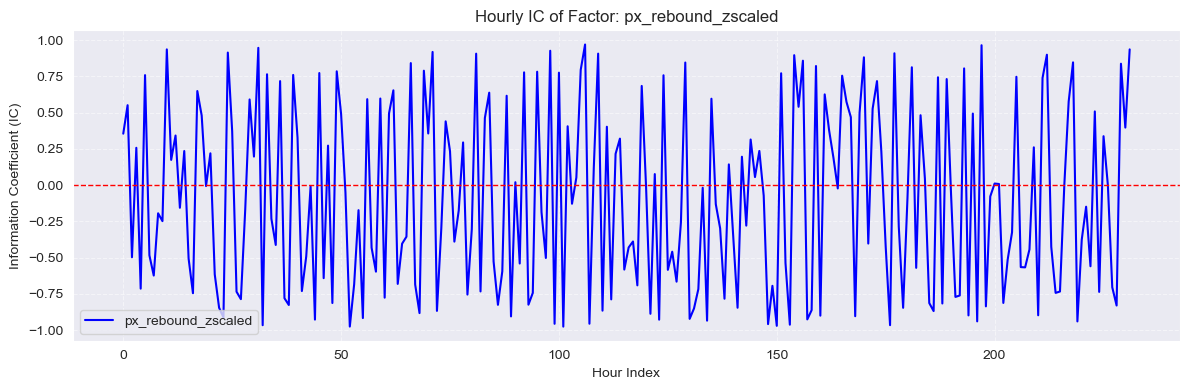

In [72]:
plot_factor_ic_timeseries(hourly_ic_df, factor_name=target_factor)


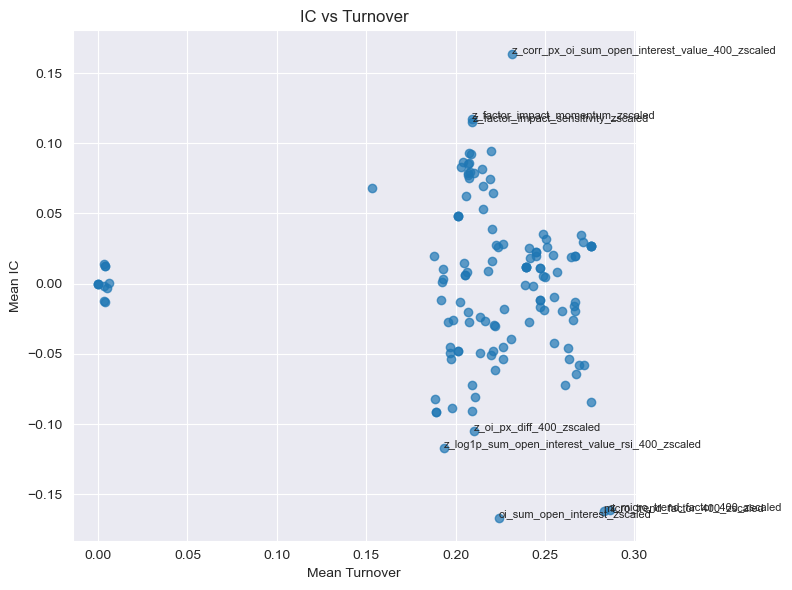

In [73]:
plot_ic_vs_turnover(ic_df.to_pandas())

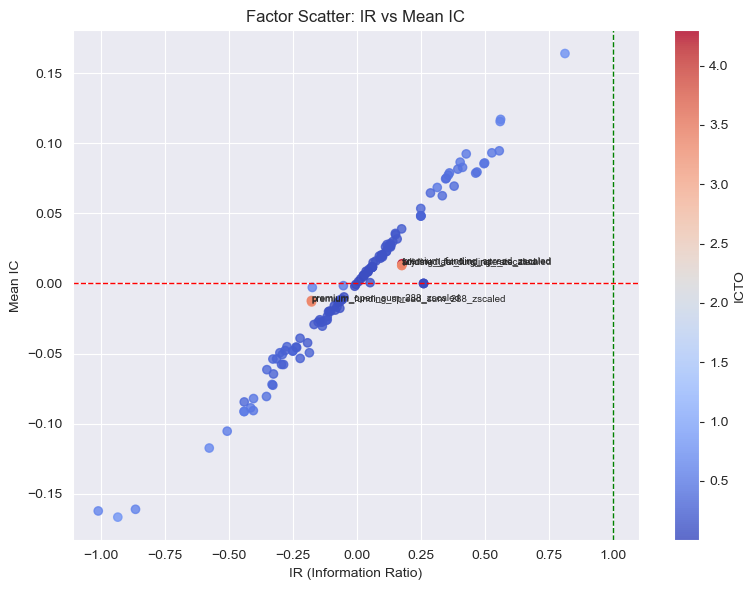

In [74]:
plot_ic_vs_ir(ic_df.to_pandas())

125       0.354598
258       0.905418
391       0.408336
524       0.665574
657      -0.047958
           ...    
30316   -22.526202
30449   -23.355877
30582   -22.519200
30715   -22.122645
30848   -21.187219
Name: cum_ic, Length: 232, dtype: float64


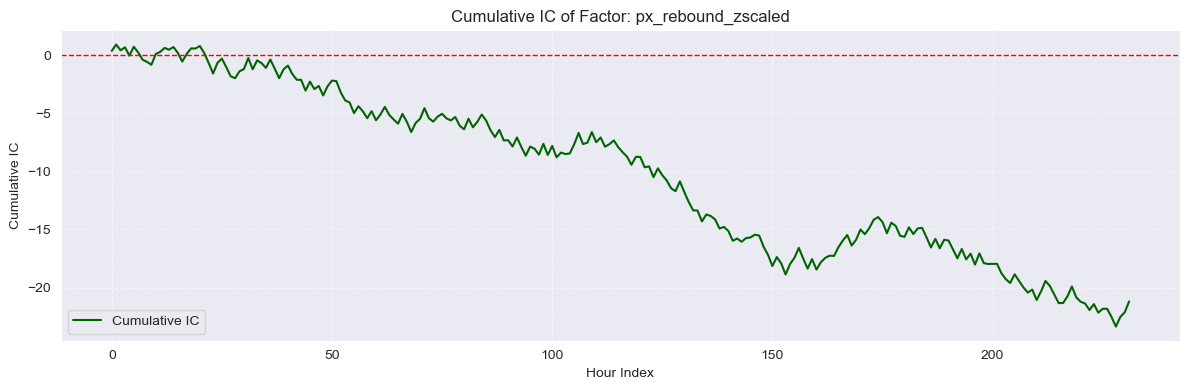

In [75]:
plot_cumulative_ic(hourly_ic_df, factor_name=target_factor)

每组平均收益：
 bin
0     0.022986
1    -0.002349
2    -0.013466
3    -0.026202
4    -0.007984
5     0.014719
6     0.002384
7     0.000955
8     0.002400
9     0.006840
10    0.010131
11    0.019094
12    0.001316
13    0.010086
14    0.002676
Name: future_return_61, dtype: float64
多空组合收益： -0.020309930586380347


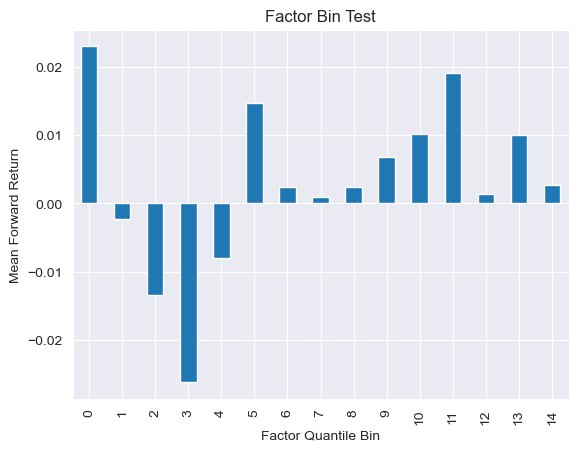

In [76]:
import pandas as pd

def factor_bin_backtest(df, factor_col="factor", ret_col="fwd_ret", n_bins=5):
    """
    分组bin回测
    """
    df = df.copy()
    
    # 按因子值分组
    df["bin"] = pd.qcut(df[factor_col], q=n_bins, labels=False)  # 分位数分箱
    
    # 计算每组收益
    grouped = df.groupby("bin")[ret_col].mean()
    
    # 多空组合收益（最高组 - 最低组）
    long_short = grouped.iloc[-1] - grouped.iloc[0]
    
    return grouped, long_short


# 示例
# 假设 df 里已经有因子值和未来收益
grouped_ret, ls_ret = factor_bin_backtest(origin_df.to_pandas(), target_factor, target_col, n_bins=15)

print("每组平均收益：\n", grouped_ret)
print("多空组合收益：", ls_ret)
import matplotlib.pyplot as plt

grouped_ret.plot(kind="bar")
plt.title("Factor Bin Test")
plt.xlabel("Factor Quantile Bin")
plt.ylabel("Mean Forward Return")
plt.show()


shape: (5, 274)
┌────────────┬─────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ timestamp  ┆ px      ┆ sum_buy_s ┆ sum_sell_ ┆ … ┆ future_re ┆ future_re ┆ future_re ┆ factor_me │
│ ---        ┆ ---     ┆ z         ┆ sz        ┆   ┆ turn_3    ┆ turn_9    ┆ turn_61   ┆ an        │
│ i64        ┆ f64     ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│            ┆         ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪═════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1719796327 ┆ 3482.94 ┆ 38834.506 ┆ 25237.172 ┆ … ┆ -0.006747 ┆ -0.018858 ┆ -0.116069 ┆ 0.0       │
│ 045000     ┆         ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 1719797606 ┆ 3506.28 ┆ 64704.413 ┆ 59558.72  ┆ … ┆ -0.006748 ┆ -0.031021 ┆ -0.127836 ┆ 0.045664  │
│ 385000     ┆         ┆           ┆           ┆   ┆           ┆           

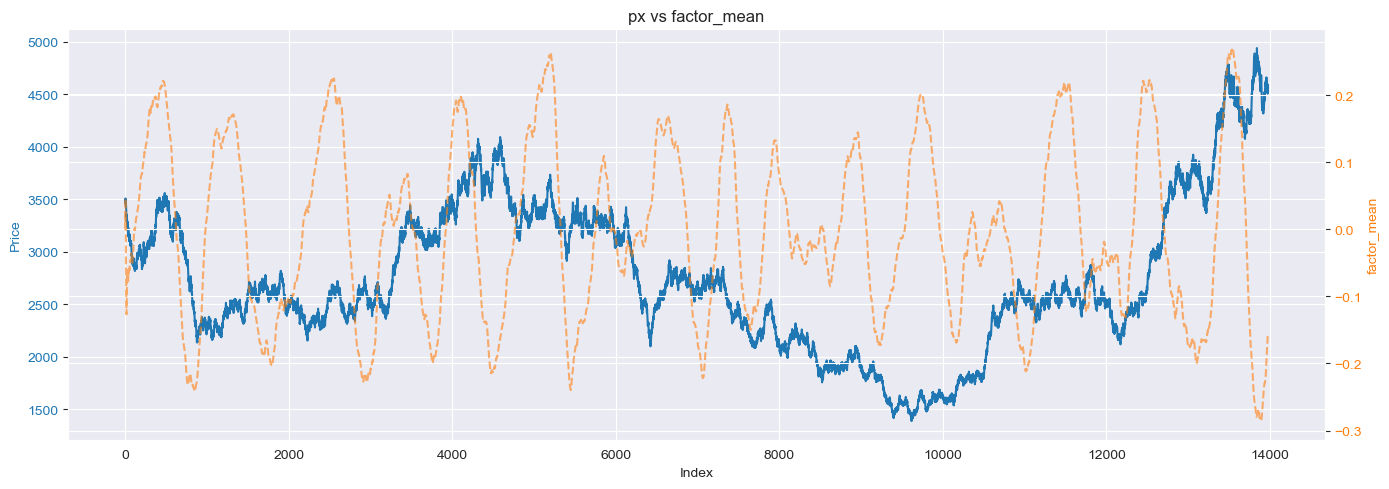

In [77]:
import polars as pl
import matplotlib.pyplot as plt

def plot_price_and_factor_mean(
    df: pl.DataFrame,
    price_col: str,
    factor_mean_col: str,
    n: int = 300
):
    # 先选择需要的列，取最后n条，转成pandas
    df_plot = df.select([price_col, factor_mean_col]).head(n).to_pandas()

    fig, ax1 = plt.subplots(figsize=(14, 5))
    ax1.set_xlabel("Index")
    ax1.set_ylabel("Price", color="tab:blue")
    ax1.plot(df_plot[price_col], color="tab:blue", label="Price")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel(factor_mean_col, color="tab:orange")
    ax2.plot(df_plot[factor_mean_col], color="tab:orange", linestyle="--", alpha=0.6, label="Factor Mean")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    plt.title(f"{price_col} vs {factor_mean_col}")
    fig.tight_layout()
    plt.grid(True)
    plt.show()


exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
co = [
    col for col in origin_df.columns
    if (col.endswith("_zscaled") and col.startswith("z_"))
        and all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "px"
]
plot_df = origin_df.with_columns(
    pl.mean_horizontal(co).alias("factor_mean")
)

# 确认数据
print(plot_df.head())

# 调用绘图函数，传入含有 px 和 factor_mean 的 DataFrame
plot_price_and_factor_mean(
    df=plot_df,
    price_col="px",            # 你要画的价格列
    factor_mean_col="factor_mean",
    n=1000000
)


[固定阈值] upper=0.0466, lower=-0.0597

=== Strategy Summary (TREND) | Rolling: False ===
Total Trades      : 30
Winning Rate      : 60.00%
Strategy Return   : 176.97%
Benchmark Return  : 30.19%
Max Drawdown      : -64.29% at index 11813
Long Trades       : 15
Short Trades      : 16


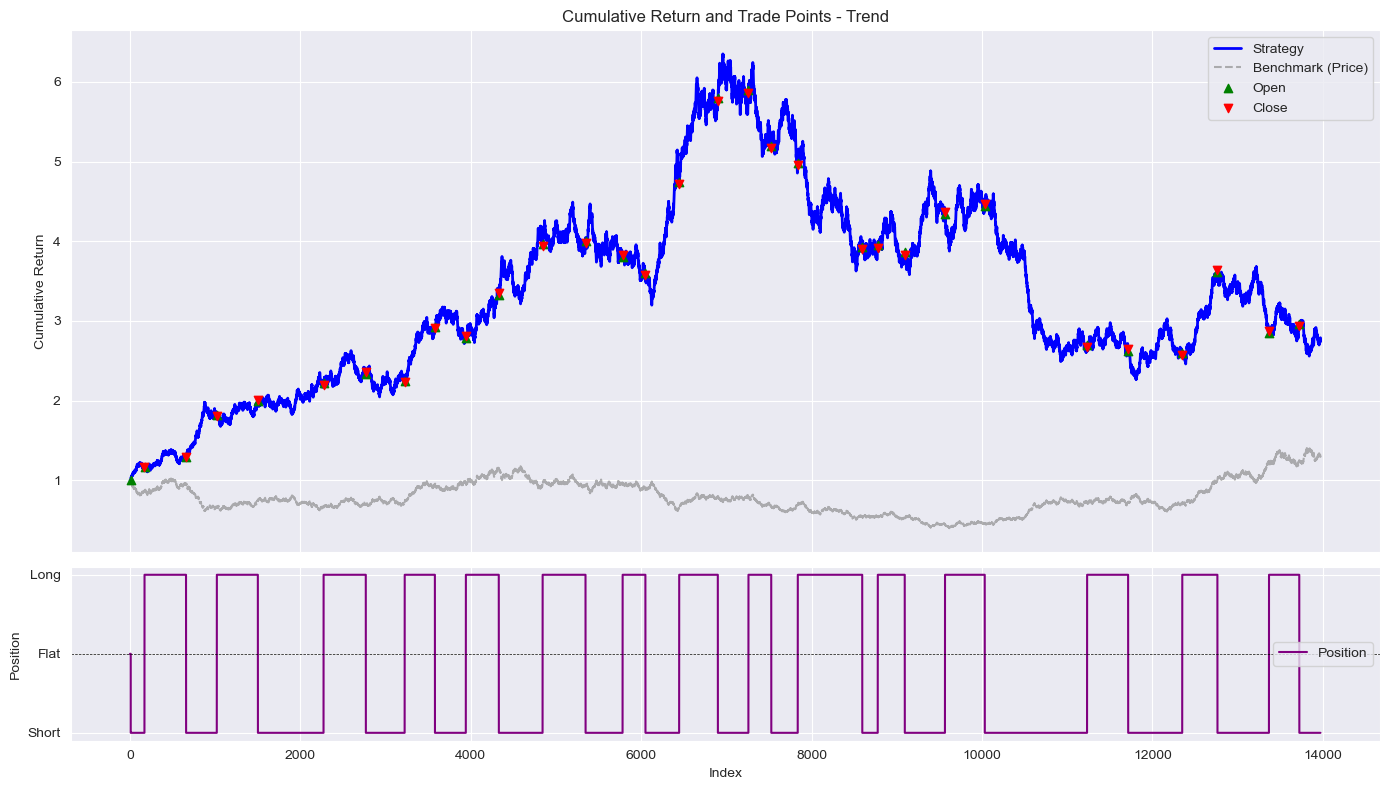

[固定阈值] upper=0.0466, lower=-0.0597

=== Strategy Summary (MEAN_REVERSION) | Rolling: False ===
Total Trades      : 30
Winning Rate      : 40.00%
Strategy Return   : -80.81%
Benchmark Return  : 30.19%
Max Drawdown      : -88.52% at index 6960
Long Trades       : 16
Short Trades      : 15


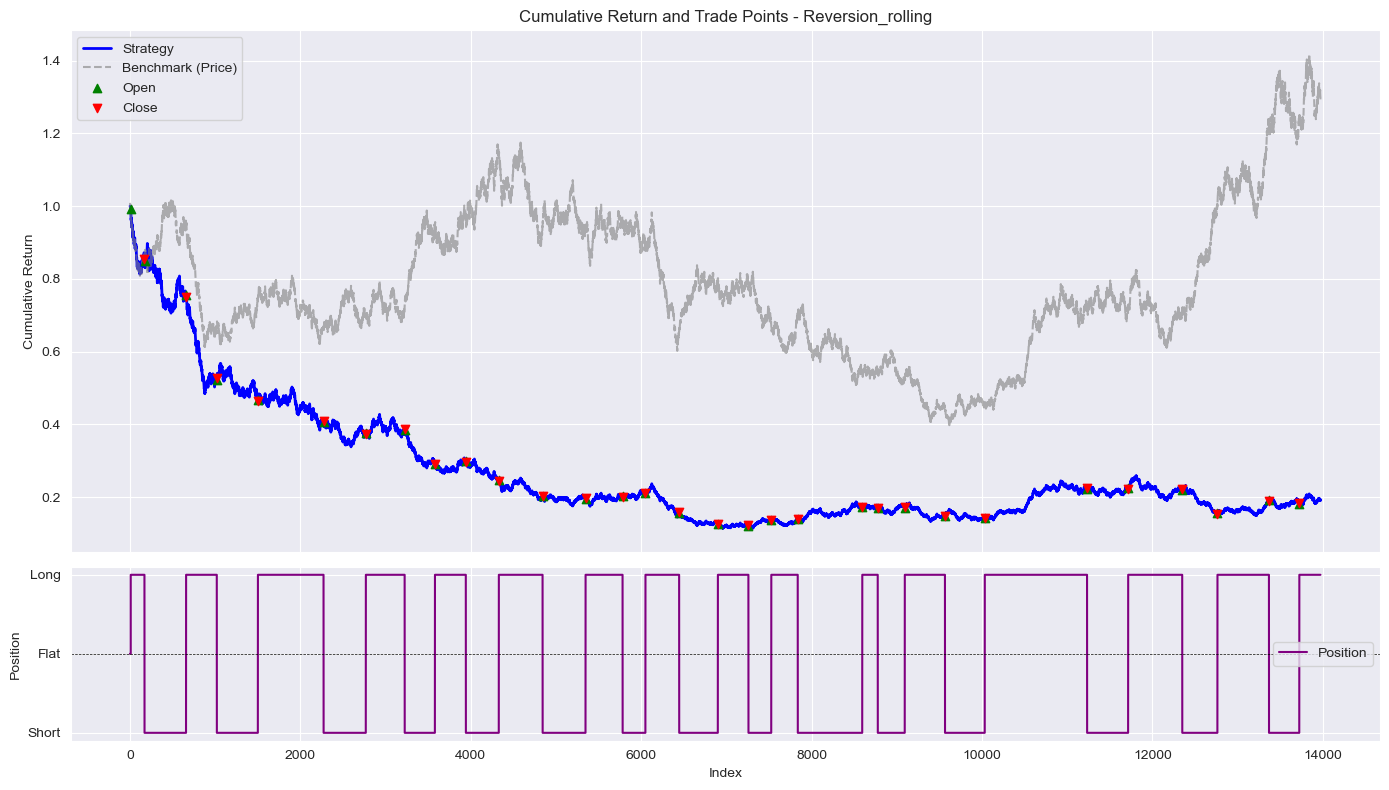

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_max_drawdown(cum_returns: pd.Series):
    roll_max = cum_returns.cummax()
    drawdown = (cum_returns - roll_max) / roll_max
    return drawdown.min(), drawdown.idxmin()

def strategy_with_position_logic(
    df: pd.DataFrame,
    price_col: str = "px",
    factor_col: str = "factor_mean",
    upper_q: float = 0.65,
    lower_q: float = 0.35,
    mode: str = "trend",
    rolling_quantile: bool = False,
    window: int = 50
) -> pd.DataFrame:
    df = df.copy()

    if rolling_quantile:
        df["upper"] = df[factor_col].rolling(window=window, min_periods=1).quantile(upper_q)
        df["lower"] = df[factor_col].rolling(window=window, min_periods=1).quantile(lower_q)
    else:
        upper = df[factor_col].quantile(upper_q)
        lower = df[factor_col].quantile(lower_q)
        df["upper"] = upper
        df["lower"] = lower
        print(f"[固定阈值] upper={upper:.4f}, lower={lower:.4f}")


    if mode == "trend":
        df["signal"] = np.where(df[factor_col] > df["upper"], 1,
                         np.where(df[factor_col] < df["lower"], -1, 0))
    elif mode == "mean_reversion":
        df["signal"] = np.where(df[factor_col] > df["upper"], -1,
                         np.where(df[factor_col] < df["lower"], 1, 0))
    else:
        raise ValueError("mode must be 'trend' or 'mean_reversion'")

    # === 仓位逻辑 & 收益计算略，保持不变 ===
    # 以下部分和你原来的逻辑一致（略去重复部分）

    # 仓位计算
    position = [0]
    trades = []  # (idx, open/close, dir)

    for i in range(1, len(df)):
        prev_pos = position[-1]
        signal = df.at[i, "signal"]

        if prev_pos == 0:
            position.append(signal)
            if signal != 0:
                trades.append((i, "open", signal))
        else:
            if signal != 0 and np.sign(signal) != np.sign(prev_pos):
                position.append(0)
                trades.append((i, "close", prev_pos))
            else:
                position.append(prev_pos)

    df["position"] = position
    df["returns"] = df[price_col].pct_change().fillna(0)
    df["strategy_returns"] = df["position"] * df["returns"]
    df["cum_strategy"] = (1 + df["strategy_returns"]).cumprod()
    df["cum_benchmark"] = (1 + df["returns"]).cumprod()

    # 胜率统计
    win = 0
    loss = 0
    trade_returns = []

    for i in range(1, len(trades)):
        if trades[i-1][1] == "open" and trades[i][1] == "close":
            entry_idx = trades[i-1][0]
            exit_idx = trades[i][0]
            direction = trades[i-1][2]
            r = (df.loc[exit_idx, price_col] / df.loc[entry_idx, price_col] - 1) * direction
            trade_returns.append(r)
            if r > 0:
                win += 1
            else:
                loss += 1

    win_rate = win / (win + loss) if (win + loss) > 0 else 0

    # 最大回撤
    mdd, mdd_idx = compute_max_drawdown(df["cum_strategy"])

    print(f"\n=== Strategy Summary ({mode.upper()}) | Rolling: {rolling_quantile} ===")
    print(f"Total Trades      : {win + loss}")
    print(f"Winning Rate      : {win_rate:.2%}")
    print(f"Strategy Return   : {df['cum_strategy'].iloc[-1] - 1:.2%}")
    print(f"Benchmark Return  : {df['cum_benchmark'].iloc[-1] - 1:.2%}")
    print(f"Max Drawdown      : {mdd:.2%} at index {mdd_idx}")
    print(f"Long Trades       : {sum([t[2] == 1 for t in trades if t[1] == 'open'])}")
    print(f"Short Trades      : {sum([t[2] == -1 for t in trades if t[1] == 'open'])}")

    df["trade_marker"] = ""
    for idx, action, direction in trades:
        df.at[idx, "trade_marker"] = "open" if action == "open" else "close"

    return df

def plot_strategy(df: pd.DataFrame, price_col="px", mode="trend"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # 策略和benchmark累计收益
    ax1.plot(df["cum_strategy"], label="Strategy", linewidth=2, color="blue")
    ax1.plot(df["cum_benchmark"], label="Benchmark (Price)", linestyle="--", alpha=0.6, color="gray")

    # 开仓/平仓点
    open_idx = df.index[df["trade_marker"] == "open"]
    close_idx = df.index[df["trade_marker"] == "close"]
    ax1.scatter(open_idx, df["cum_strategy"].iloc[open_idx], color="green", marker="^", label="Open", zorder=5)
    ax1.scatter(close_idx, df["cum_strategy"].iloc[close_idx], color="red", marker="v", label="Close", zorder=5)

    ax1.set_title(f"Cumulative Return and Trade Points - {mode.capitalize()}")
    ax1.set_ylabel("Cumulative Return")
    ax1.grid(True)
    ax1.legend()

    # 仓位图
    ax2.plot(df["position"], color="purple", drawstyle='steps-post', label="Position")
    ax2.axhline(0, color="black", linestyle="--", linewidth=0.5)
    ax2.set_ylabel("Position")
    ax2.set_xlabel("Index")
    ax2.set_yticks([-1, 0, 1])
    ax2.set_yticklabels(["Short", "Flat", "Long"])
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()


df_plot = plot_df.select(["px", "factor_mean"]).to_pandas()

# 趋势策略
trend_df_roll = strategy_with_position_logic(df_plot, mode="trend", rolling_quantile=False, window=140)
plot_strategy(trend_df_roll, mode="trend")

# # 回归策略
revert_df_roll = strategy_with_position_logic(df_plot, mode="mean_reversion", rolling_quantile=False, window=140)
plot_strategy(revert_df_roll, mode="reversion_rolling")
#origin_df = pl.read_csv("C:/quant/data/binance_resampled_data/BTCUSDT_factors_threshold0.001_rolling200.csv")


In [79]:
def strategy_with_position_logic(
    df: pd.DataFrame,
    price_col: str = "px",
    factor_col: str = "factor_mean",
    upper_q: float = 0.5,
    lower_q: float = 0.5,
    mode: str = "trend",
    rolling_quantile: bool = False,
    window: int = 50
) -> pd.DataFrame:
    df = df.copy()

    # === 阈值计算 ===
    if rolling_quantile:
        df["upper"] = df[factor_col].rolling(window=window, min_periods=1).quantile(upper_q)
        df["lower"] = df[factor_col].rolling(window=window, min_periods=1).quantile(lower_q)
    else:
        upper = df[factor_col].quantile(upper_q)
        lower = df[factor_col].quantile(lower_q)
        df["upper"] = upper
        df["lower"] = lower
        print(f"[固定阈值] upper={upper:.4f}, lower={lower:.4f}")


    # === 生成信号 ===
    if mode == "trend":
        df["signal"] = np.where(df[factor_col] > df["upper"], 1,
                         np.where(df[factor_col] < df["lower"], -1, 0))
    elif mode == "mean_reversion":
        df["signal"] = np.where(df[factor_col] > df["upper"], -1,
                         np.where(df[factor_col] < df["lower"], 1, 0))
    else:
        raise ValueError("mode must be 'trend' or 'mean_reversion'")

    # === 仓位逻辑（直接跟随信号，不延续持仓）===
    df["position"] = df["signal"]

    # === 收益计算 ===
    df["returns"] = df[price_col].pct_change().fillna(0)
    df["strategy_returns"] = df["position"].shift(1).fillna(0) * df["returns"]  # 防止未来函数
    df["cum_strategy"] = (1 + df["strategy_returns"]).cumprod()
    df["cum_benchmark"] = (1 + df["returns"]).cumprod()

    # === 交易点标记 ===
    df["trade_marker"] = ""
    df.loc[df["signal"].diff() != 0, "trade_marker"] = "open"

    return df


[固定阈值] upper=-0.0137, lower=-0.0137


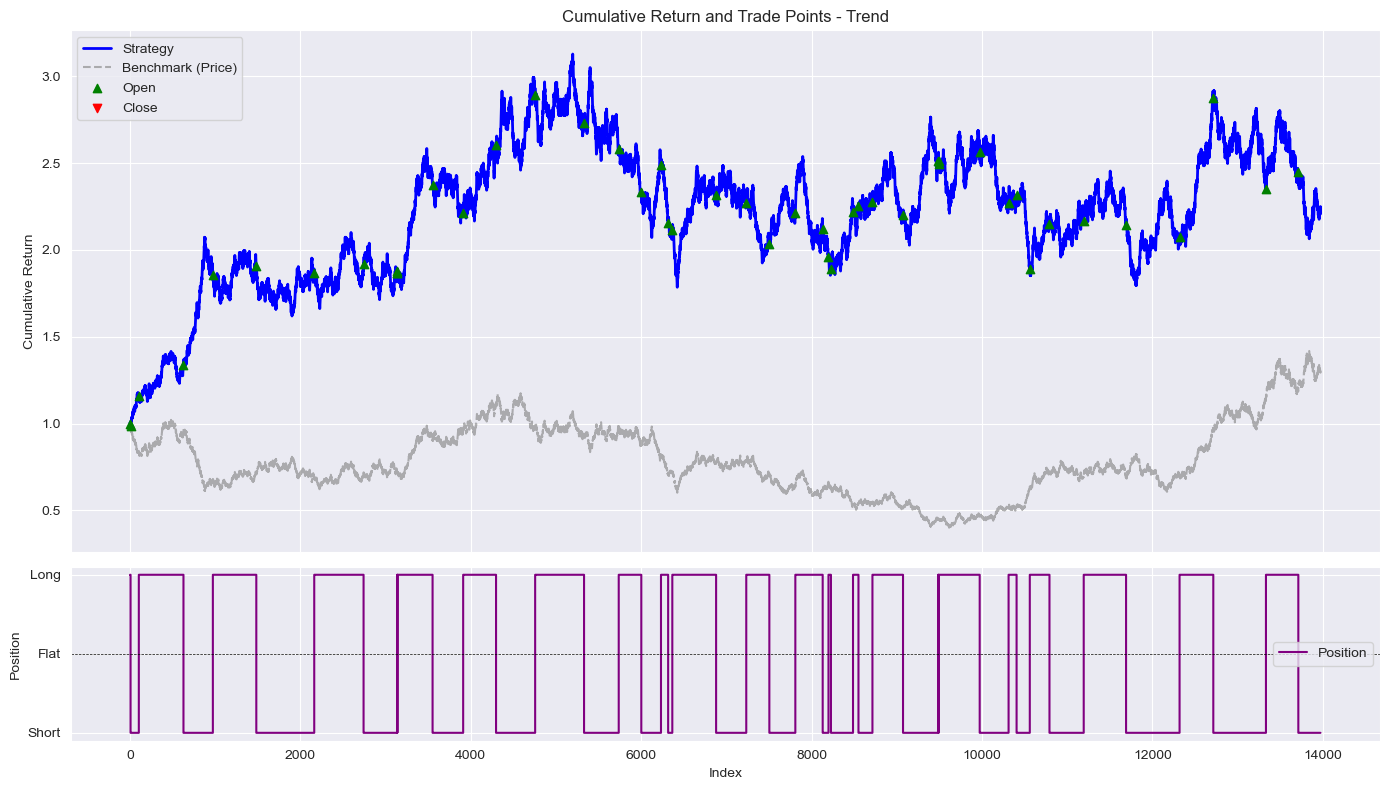

[固定阈值] upper=-0.0137, lower=-0.0137


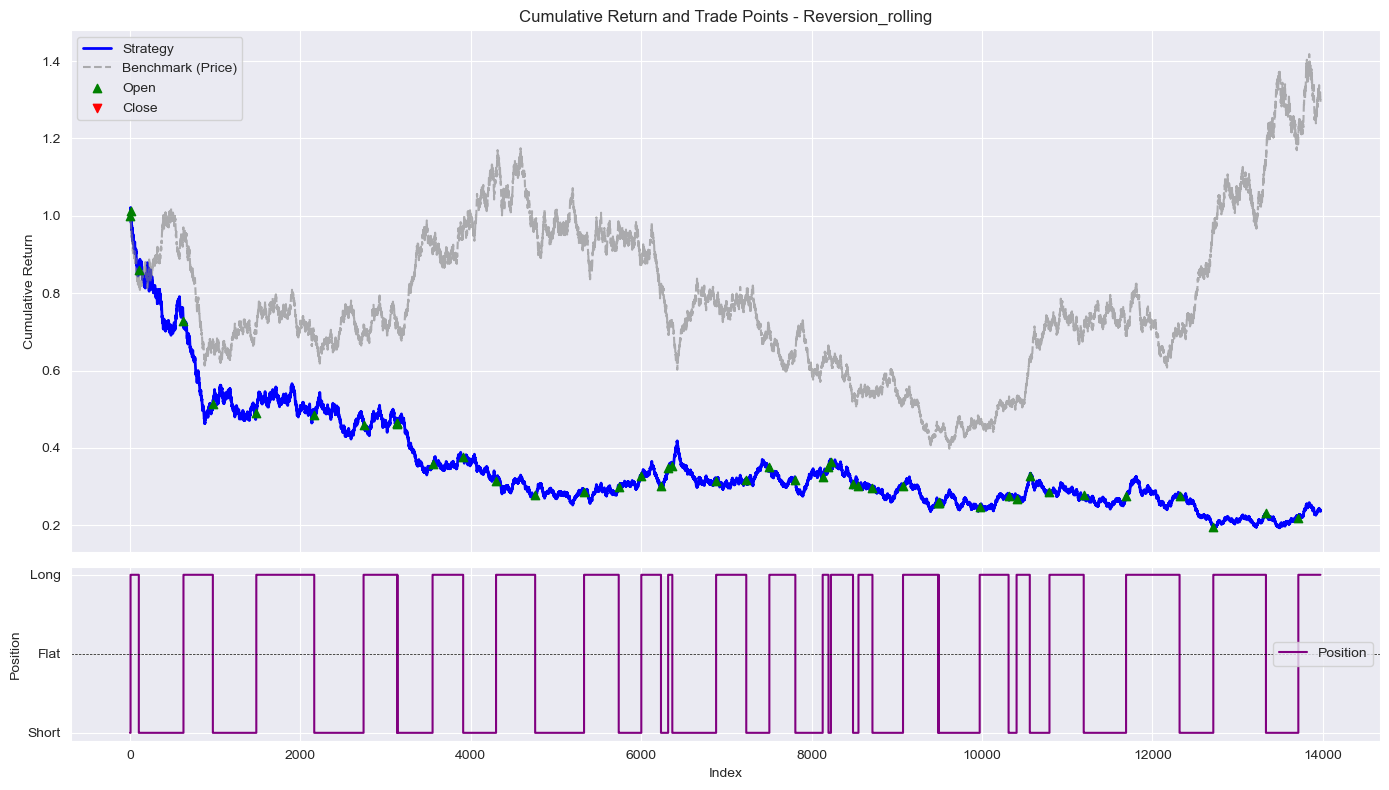

In [80]:
df_plot = plot_df.select(["px", "factor_mean"]).to_pandas()

# 趋势策略
trend_df_roll = strategy_with_position_logic(df_plot, mode="trend", rolling_quantile=False, window=2000)
plot_strategy(trend_df_roll, mode="trend")

# 回归策略
revert_df_roll = strategy_with_position_logic(df_plot, mode="mean_reversion", rolling_quantile=False, window=2000)
plot_strategy(revert_df_roll, mode="reversion_rolling")
